# 📓 Muon Detection through Three Layers of Plastic Scintillator
**Author:** Arpad Schaeffer et Malo Tamalet



# Détection de muons à travers trois couches de scintillateur plastique

Dans ce notebook, nous présentons une étude expérimentale visant à détecter des muons cosmiques à l'aide de trois couches de scintillateur plastique, couplées à des photomultiplicateurs (PM) et reliées à un système d'acquisition. 

L'objectif est double :
1. Visualiser les signaux issus de l'oscilloscope pour identifier les événements caractéristiques des muons.
2. Caractériser les performances du système de détection (résolution temporelle, taux de comptage, coïncidences, efficacité de détection).

Ce document servira de base à l’analyse des données expérimentales et à l’interprétation physique des résultats.


In [28]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import pyvisa
import time
import re


## Partie 1 Acquisition des données depuis l'oscilloscope

Ressources disponibles : ('ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR', 'USB0::0x0699::0x03A6::C057600::INSTR')
Identification de l'instrument : TEKTRONIX,TDS 2024C,C057600,CF:91.1CT FV:v24.26

CH1 est actif avec 2500 points récupérés.
CH2 est actif avec 2500 points récupérés.
CH3 n'est pas utilisé (erreur: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.).
Données enregistrées dans /Users/malotamalet/Desktop/Modal/Modal/Data/Data_28-03-2025_11-58_CH1_CH2.csv
Plot enregistré dans /Users/malotamalet/Desktop/Modal/Modal/Data/Plot_28-03-2025_11-58_CH1_CH2.png


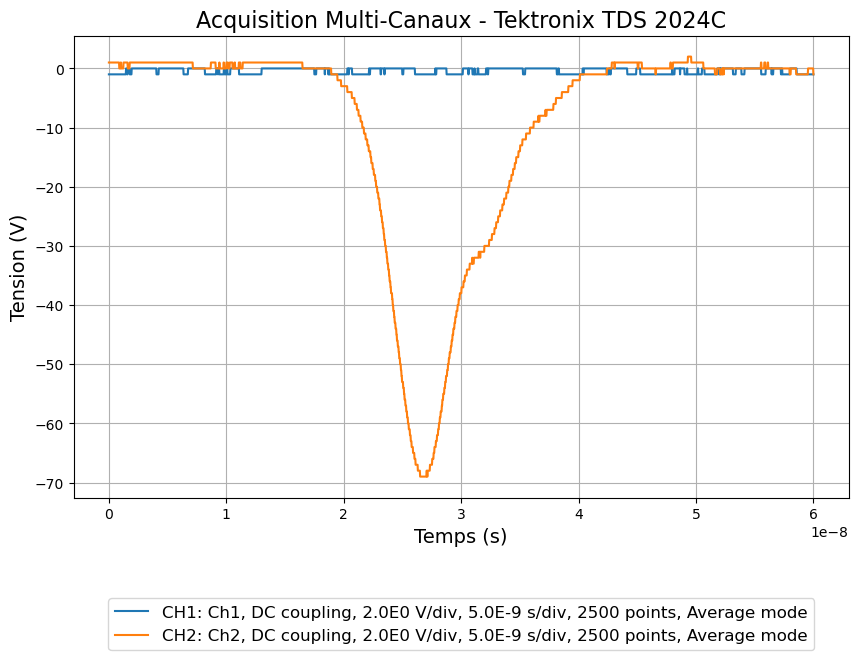

In [32]:
# Définissez cette constante sur True pour enregistrer les données
SAVE_DATA = True

def get_channel_data(scope, channel):
    """
    Configure le canal, récupère le préambule et la courbe de données.
    Retourne un tuple contenant :
      - les points de données (numpy array),
      - la chaîne du préambule,
      - l'info du canal extraite (ex. "ChX, DC coupling, ..."),
      - le nombre de points.
    """
    # Configuration du canal
    scope.write(f"DATA:SOURCE {channel}")
    scope.write("DATA:WIDTH 1")
    scope.write("DATA:ENCdg ASCii")
    
    # Récupération du préambule
    preamble = scope.query("WFMPRE?")
    preamble_fields = preamble.split(';')
    
    # Extraction de l'info du canal (champ 7) avec vérification de la longueur
    if len(preamble_fields) > 6:
        channel_info = preamble_fields[6].strip('"')
    else:
        channel_info = "Information indisponible"
    
    # Extraction du nombre de points (champ 6)
    try:
        num_points = int(preamble_fields[5])
    except Exception:
        num_points = None
    
    # Récupération des données de la courbe
    data_str = scope.query("CURVE?")
    try:
        data_points = np.array(data_str.strip().split(','), dtype=float)
    except Exception as e:
        print(f"Erreur lors de la conversion des données pour {channel}: {e}")
        data_points = np.array([])
    
    return data_points, preamble, channel_info, num_points

# Crée le gestionnaire de ressources VISA
rm = pyvisa.ResourceManager()

# Affiche les ressources disponibles
resources = rm.list_resources()
print("Ressources disponibles :", resources)

# Chaîne de ressource pour l'oscilloscope Tektronix
resource_str = 'USB0::0x0699::0x03A6::C057600::INSTR'
scope = rm.open_resource(resource_str)

# Affiche l'identification de l'instrument
idn_response = scope.query("*IDN?")
print("Identification de l'instrument :", idn_response)

# Délai pour que l'acquisition soit prête
scope.timeout = 5000

# Liste des canaux à tester
channels = ["CH1", "CH2", "CH3"]
active_channels = {}

# Pour chaque canal, on tente de récupérer ses données.
for ch in channels:
    try:
        data, preamble, info, num_points = get_channel_data(scope, ch)
        # On considère le canal actif s'il renvoie au moins quelques points
        if len(data) > 0:
            active_channels[ch] = {"data": data, "preamble": preamble, "info": info, "num_points": num_points}
            print(f"{ch} est actif avec {len(data)} points récupérés.")
        else:
            print(f"{ch} n'est pas utilisé (aucune donnée récupérée).")
    except pyvisa.errors.VisaIOError as e:
        print(f"{ch} n'est pas utilisé (erreur: {e}).")

if not active_channels:
    print("Aucun canal actif détecté.")
    exit()

# Utilisation du premier canal actif pour construire le vecteur temps
first_active_channel = next(iter(active_channels))
first_data = active_channels[first_active_channel]
info_first = first_data["info"]
num_points = first_data["num_points"]

# Extraction du réglage horizontal (temps/div) depuis l'info du premier canal actif
match_time = re.search(r'([\d.Ee+-]+)\s*s/div', info_first)
if match_time and num_points:
    time_per_div = float(match_time.group(1))
    # On suppose ici 12 divisions horizontales
    total_time = time_per_div * 12
    time_vector = np.linspace(0, total_time, num_points)
    x_label = "Temps (s)"
else:
    time_vector = np.arange(len(first_data["data"]))
    x_label = "Index (points)"

y_label = "Tension (V)"

# Tracé des données des canaux actifs sur le même graphique
plt.figure(figsize=(10, 6))
for ch, vals in active_channels.items():
    # On peut insérer un saut de ligne dans le label si souhaité, ici chaque entrée sera sur une ligne
    label_text = f"{ch}: {vals['info']}"
    plt.plot(time_vector, vals["data"], label=label_text)
plt.title("Acquisition Multi-Canaux - Tektronix TDS 2024C", fontsize=16)
plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.grid(True)

# Positionnement de la légende en dessous du graphique, en une seule colonne (une ligne par canal)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize=12, ncol=1)

# Enregistrement des données dans un fichier CSV si SAVE_DATA est True
if SAVE_DATA:
    data_dict = {x_label: time_vector}
    for ch, vals in active_channels.items():
        data_dict[f"{ch} (V)"] = vals["data"]
    df = pd.DataFrame(data_dict)
    
    # Création d'une chaîne de caractères pour la date et l'heure courante au format "jour-mois-année_heure-minute"
    import datetime
    date_str = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M")
    
    # Création d'une chaîne listant les canaux utilisés séparés par un underscore
    channels_used = "_".join(active_channels.keys())
    
    # Création du nom de fichier avec la date et les canaux utilisés
    filename = f"/Users/malotamalet/Desktop/Modal/Modal/Data/Data_{date_str}_{channels_used}.csv"
    
    df.to_csv(filename, index=False)
    print(f"Données enregistrées dans {filename}")

    # Enregistrement du plot dans le même dossier
    plot_filename = f"/Users/malotamalet/Desktop/Modal/Modal/Data/Plot_{date_str}_{channels_used}.png"
    plt.savefig(plot_filename, bbox_inches='tight')
    print(f"Plot enregistré dans {plot_filename}")

    plt.show()

## Partie 2 – Visualisation des signaux issus de l’oscilloscope

Dans cette section, nous allons importer des données issues d’un oscilloscope (formes d’ondes), les afficher, et analyser les caractéristiques des signaux : largeur d’impulsion, amplitude, forme typique des événements, etc.

In [ ]:
# Exemple : chargement de données CSV exportées depuis un oscilloscope
data = pd.read_csv("oscilloscope_data.csv")
time = data['Time (ns)']
signal_ch1 = data['CH1']
signal_ch2 = data['CH2']

# Aperçu des premières lignes
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'oscilloscope_data.csv'

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(time, signal_ch1, label='Canal 1 (scintillateur 1)')
plt.plot(time, signal_ch2, label='Canal 2 (scintillateur 2)', alpha=0.7)
plt.xlabel("Temps (ns)")
plt.ylabel("Amplitude (V)")
plt.title("Signaux typiques détectés sur l’oscilloscope")
plt.legend()
plt.grid(True)
plt.figtext(0.5, -0.1, "Figure: Signaux typiques détectés sur l’oscilloscope", wrap=True, horizontalalignment='center', fontsize=10)  # Légende de la figure
plt.show()

NameError: name 'plt' is not defined

## Partie 3 Regression pour modélisation du pic

In [ ]:
# Chemin vers le fichier CSV avec header
csv_file = "/Users/malotamalet/Desktop/Modal/Data/Data_14-03-2025_17-56_CH2.csv"  # Remplacez par le chemin réel

# Lecture du CSV avec header
df = pd.read_csv(csv_file)

# Affichage des premières lignes pour vérifier le contenu
print(df.head())

# Extraction des données pour le graphique
# Ici, "Temps (s)" est utilisé pour l'axe des abscisses, et "CH2 (V)" pour les valeurs
x_data = df["Temps (s)"].values
y_data = df["CH2 (V)"].values

# Optionnel : tracé brut des données pour vérification
if False:
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'ko', markersize=3, label="Données brutes")
    plt.xlabel("Temps (s)")
    plt.ylabel("CH2 (V)")
    plt.title("Données brutes extraites du CSV")
    plt.grid(True)
    plt.legend()
    plt.show()

# Choix du mode de régression : "desc", "asc" ou "both"
regression_mode = "desc"  # Modifiez cette variable pour choisir le mode souhaité

# Définition de la fonction exponentielle à ajuster : y = a * exp(b*x) + c
def expo_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Pour l'ajustement, on cherche des indices correspondant à certaines valeurs dans y_data.
min_index = np.where(np.isclose(y_data, -75, atol=1e-1))[0][0]
max_index = np.where(np.isclose(y_data, -75, atol=1e-2))[0][-1]
print("Indices utilisés :", x_data[min_index], y_data[min_index], x_data[max_index], y_data[max_index])

# Séparation des données en deux parties :
# Descente : du début jusqu'au point de min_index
x_desc = x_data[:min_index+1]
y_desc = y_data[:min_index+1]

# Montée : du point de max_index jusqu'à la fin
x_asc = x_data[max_index:]
y_asc = y_data[max_index:]

# Initialisation des variables
popt_desc = None
popt_asc = None
y_fit_desc = None
y_fit_asc = None
tau_desc = None
tau_asc = None

# Régression sur la descente si demandée
if regression_mode in ["desc", "both"]:
    popt_desc, _ = curve_fit(expo_func, x_desc, y_desc, p0=(-1, 10**9, 0))
    y_fit_desc = expo_func(x_desc, *popt_desc)
    tau_desc = 1.0 / popt_desc[1]
    print("Paramètres pour la descente (a, b, c) :", popt_desc)
    print("Temps caractéristique descente (tau):", tau_desc)

# Régression sur la montée si demandée
if regression_mode in ["asc", "both"]:
    popt_asc, _ = curve_fit(expo_func, x_asc, y_asc, p0=(-1, -10**9, 0))
    y_fit_asc = expo_func(x_asc, *popt_asc)
    tau_asc = 1.0 / popt_asc[1]
    print("Paramètres pour la montée (a, b, c)   :", popt_asc)
    print("Temps caractéristique montée (tau):", tau_asc)

# Tracé des données et des ajustements
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'ko', markersize=3, label="Données brutes")
if regression_mode in ["desc", "both"]:
    plt.plot(x_desc, y_fit_desc, 'b-', linewidth=2, label="Régression exponentielle (descente)")
if regression_mode in ["asc", "both"]:
    plt.plot(x_asc, y_fit_asc, 'r-', linewidth=2, label="Régression exponentielle (montée)")
plt.xlabel("Temps (s)")
plt.ylabel("CH2 (V)")
plt.title("Graphique des données et régressions exponentielles")
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=1)

# Affichage des constantes et de τ sur le graphique, le cas échéant
ax = plt.gca()
if regression_mode in ["desc", "both"]:
    text_desc = (
        "Descente:\n"
        "a=" + f"{popt_desc[0]:.3g}" +
        ", b=" + f"{popt_desc[1]:.3g}" +
        ", c=" + f"{popt_desc[2]:.3g}" + "\n\n" +
        "$\\mathbf{\\tau} = 1/b = " + f"{tau_desc:.3e}" + "$"
    )
    ax.text(0.05, 0.75, text_desc, transform=ax.transAxes, fontsize=10, verticalalignment='top', color='blue')
if regression_mode in ["asc", "both"]:
    text_asc = (
        "Montée:\n"
        "a=" + f"{popt_asc[0]:.3g}" +
        ", b=" + f"{popt_asc[1]:.3g}" +
        ", c=" + f"{popt_asc[2]:.3g}" + "\n\n" +
        "$\\mathbf{\\tau} = 1/b = " + f"{tau_asc:.3e}" + "$"
    )
    ax.text(0.05, 0.60, text_asc, transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

plt.tight_layout()
plt.show()

## Partie 4 Caractérisation du système de détection

Nous allons ici explorer plusieurs éléments :
- Le taux de comptage individuel des scintillateurs.
- Le taux de coïncidences doubles et triples.
- L'efficacité relative des détecteurs.
- L'estimation de la résolution temporelle.

### IV.1 Étude de la réponse en tension

Dans cette sous-section, nous analysons comment le nombre de détections (counts) varie en fonction de la tension appliquée aux scintillateurs. Cela permet de caractériser la sensibilité du système de détection en fonction de la tension.

In [ ]:
# Exemple : fichier CSV avec taux de comptage mesurés pour différents temps d’acquisition
count_data = pd.read_csv("comptage_muons.csv")
count_data.head()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(count_data['Temps (s)'], count_data['Détecteur 1'], label='Scintillateur 1')
plt.plot(count_data['Temps (s)'], count_data['Détecteur 2'], label='Scintillateur 2')
plt.plot(count_data['Temps (s)'], count_data['Coïncidence 1&2'], label='Coïncidence 1&2')
plt.plot(count_data['Temps (s)'], count_data['Triple coïncidence'], label='Triple coïncidence')
plt.xlabel("Temps d’acquisition (s)")
plt.ylabel("Nombre d’impulsions")
plt.title("Taux de comptage des détecteurs")
plt.legend()
plt.grid()
plt.show()

NameError: name 'count_data' is not defined

<Figure size 800x500 with 0 Axes>

### IV.2 Etude du treshold

Dans cette sous-section, nous cherchons un couple de valeurs efficaces entre tension et threshold pour maximiser la détection de muons mais aussi pour minimiser le bruit.

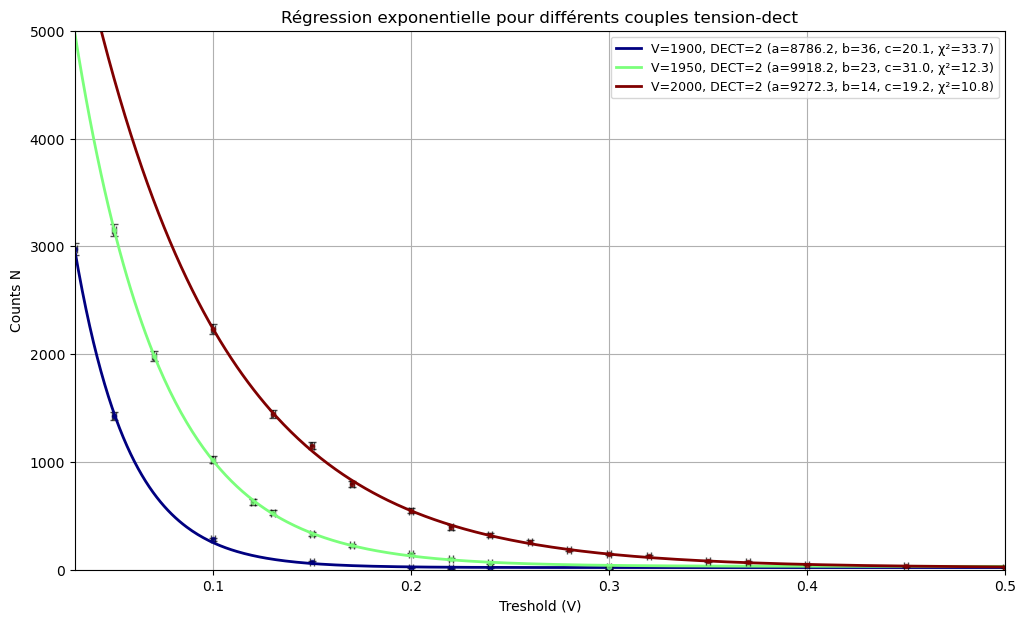

In [64]:
# ---------------------------------------------------------------------------
# Section 1 : Paramètres et définition de la fonction de régression
# ---------------------------------------------------------------------------
# Ajoutez ici vos bornes pour les axes
xmin = 0.03
xmax = 0.5
ymin = 0
ymax = 5000

# Liste des couples (tension, dect) à analyser
couples = [
    (1900, 2),
    (1950, 2),
    (2000, 2)
    # Ajoutez ici d'autres couples spécifiques si nécessaire
]

# Fonction exponentielle pour le fit : f(x) = a * exp(-b * x) + c
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# ---------------------------------------------------------------------------
# Section 2 : Configuration de la figure
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 7))
n_curves = len(couples)
cmap = plt.get_cmap('jet', n_curves)
curve_idx = 0

# ---------------------------------------------------------------------------
# Section 3 : Itération sur les jeux de données pour chaque couple tension-dect
# ---------------------------------------------------------------------------
for V, d in couples:
    filename = f"{V}_DECT{d}.csv"
    try:
        data_dect = pd.read_csv(filename)
    except Exception as e:
        print(f"Erreur lors de la lecture de {filename}: {e}")
        continue

    # Lecture des données
    x = data_dect['Tresh (V)']
    y = data_dect['N']

    # Définition des erreurs : erreur sur N (sqrt(N)) et erreur fixe sur Treshold
    y_errors = np.sqrt(y)
    x_errors = np.full_like(x, 0.001)

    # Ajustement des données par régression exponentielle
    initial_guesses = [12000, 10, 300]
    try:
        params, covariance = curve_fit(exp_func, x, y, p0=initial_guesses, maxfev=5000)
    except Exception as e:
        print(f"Erreur dans le fit pour {filename}: {e}")
        continue

    a, b, c = params

    # Génération de la courbe ajustée pour l'affichage
    x_fit = np.linspace(0.03, 0.5, 500)
    y_fit = exp_func(x_fit, a, b, c)
    
    # -----------------------------------------------------------------------
    # Calcul du chi² : χ² = Σ[((observé - ajusté)/erreur)²]
    # -----------------------------------------------------------------------
    chi2 = np.sum(((y - exp_func(x, a, b, c)) / y_errors) ** 2)

    # Couleur pour la courbe
    color = cmap(curve_idx)
    curve_idx += 1

    # -----------------------------------------------------------------------
    # Tracé des données et de l'ajustement :
    # -----------------------------------------------------------------------
    plt.errorbar(x, y, yerr=y_errors, xerr=x_errors, fmt='o', color=color, 
                 ecolor='black', capsize=3, markersize=3, alpha=0.7)
    plt.plot(x_fit, y_fit, '-', color=color, lw=2,
             label=f'V={V}, DECT={d} (a={a:.1f}, b={b:.2g}, c={c:.1f}, χ²={chi2:.1f})')

# ---------------------------------------------------------------------------
# Section 4 : Configuration finale et affichage
# ---------------------------------------------------------------------------
plt.xlabel("Treshold (V)")
plt.ylabel("Counts N")
plt.title("Régression exponentielle pour différents couples tension-dect")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend(fontsize=9)
plt.grid(True)
plt.show()